<a href="https://colab.research.google.com/github/vfrantc/deweather/blob/main/fixed_range_train_decomp_dehazing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Jul 10 12:00:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from glob import glob
import shutil

In [3]:
!pip install kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 3.9 MB/s 


In [4]:
import kornia as K

In [5]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [6]:
!git clone https://github.com/vfrantc/deweather.git

Cloning into 'deweather'...
remote: Enumerating objects: 416, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 416 (delta 103), reused 77 (delta 41), pack-reused 256
Receiving objects: 100% (416/416), 10.81 MiB | 14.74 MiB/s, done.
Resolving deltas: 100% (226/226), done.


In [7]:
%cd deweather/TransWeather-dehaze/

/content/deweather/TransWeather-dehaze


In [8]:
!cp /content/drive/MyDrive/haze/data/SOTS.zip .
!cp /content/drive/MyDrive/deweather2/reside.zip .
!unzip SOTS.zip
!unzip reside.zip 
!mkdir -p data/train/
!mkdir -p data/test/outdoor/
!cp -r hazy data/train/input 
!cp -r SOTS/outdoor/hazy data/test/outdoor/input

Streaming output truncated to the last 5000 lines.
  inflating: hazy/1822_0.8_0.08.jpg  
  inflating: hazy/1823_0.95_0.1.jpg  
  inflating: hazy/1828_0.9_0.08.jpg  
  inflating: hazy/1832_0.95_0.06.jpg  
  inflating: hazy/1875_0.8_0.06.jpg  
  inflating: hazy/1889_1_0.2.jpg     
  inflating: hazy/1911_0.9_0.06.jpg  
  inflating: hazy/1915_0.95_0.04.jpg  
  inflating: hazy/1971_0.85_0.2.jpg  
  inflating: hazy/1976_0.9_0.04.jpg  
  inflating: hazy/1977_0.9_0.2.jpg   
  inflating: hazy/1977_1_0.08.jpg    
  inflating: hazy/1979_0.85_0.12.jpg  
  inflating: hazy/1982_0.95_0.12.jpg  
  inflating: hazy/2000_0.85_0.12.jpg  
  inflating: hazy/2018_0.85_0.2.jpg  
  inflating: hazy/2020_0.9_0.1.jpg   
  inflating: hazy/2020_1_0.2.jpg     
  inflating: hazy/2026_0.9_0.04.jpg  
  inflating: hazy/2033_0.9_0.08.jpg  
  inflating: hazy/2033_0.95_0.08.jpg  
  inflating: hazy/2043_0.95_0.04.jpg  
  inflating: hazy/2060_0.8_0.04.jpg  
  inflating: hazy/2070_0.9_0.16.jpg  
  inflating: hazy/2077_0.8_0.0

In [9]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import cv2
import numpy as np
from glob import glob
from tqdm.notebook import tqdm

class DecomNet(nn.Module):
    def __init__(self, channel=64, kernel_size=5):
        super(DecomNet, self).__init__()
        # Shallow feature extraction
        self.net1_conv0 = nn.Conv2d(15, channel, kernel_size * 3,  padding=7, padding_mode='replicate')
        # Activated layers!
        self.net1_convs = nn.Sequential(nn.Conv2d(channel, channel, kernel_size, padding=2, padding_mode='replicate'),
                                        nn.ReLU(),
                                        nn.Conv2d(channel, channel, kernel_size, padding=2, padding_mode='replicate'),
                                        nn.ReLU(),
                                        nn.Conv2d(channel, channel, kernel_size, padding=2, padding_mode='replicate'),
                                        nn.ReLU(),
                                        nn.Conv2d(channel, channel, kernel_size, padding=2, padding_mode='replicate'),
                                        nn.ReLU(),
                                        nn.Conv2d(channel, channel, kernel_size, padding=2, padding_mode='replicate'),
                                        nn.ReLU())
        # Final recon layer
        self.net1_recon = nn.Conv2d(channel, 6, kernel_size, padding=2, padding_mode='replicate')

    def forward(self, input_im):
        #input_img = torch.cat((input_im, input_im), dim=1)

        grads = K.filters.spatial_gradient(input_im, order=1)  # BxCx2xHxW
        grads1_x = grads[:, :, 0]
        grads1_y = grads[:, :, 1]
        grads = K.filters.spatial_gradient(input_im, order=2)  # BxCx2xHxW
        grads2_x = grads[:, :, 0]
        grads2_y = grads[:, :, 1]

        input = torch.cat((input_im, grads1_x, grads1_y, grads2_x, grads2_y), dim=1)

        feats0   = self.net1_conv0(input)
        featss   = self.net1_convs(feats0)
        outs     = self.net1_recon(featss)
        R        = torch.sigmoid(outs[:, 0:3, :, :])
        L        = torch.sigmoid(outs[:, 3:6, :, :])
        return R, L

def get_decom(trainable=True):
  net = DecomNet().cuda()
  ckpt_dict  = torch.load('decomp.tar') # , map_location=torch.device('cpu')
  net.load_state_dict(ckpt_dict)
  for p in net.parameters():
      p.requires_grad = trainable
  return net

def decom_image(image, net):
  test_low_img   = 2 * cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0 - 1
  test_low_img   = np.transpose(test_low_img, (2, 0, 1))
  input_low_test = np.expand_dims(test_low_img, axis=0)
  input_low_test = Variable(torch.FloatTensor(torch.from_numpy(input_low_test))).cuda()
  R_low, I_low   = net(input_low_test)
  R_low = np.clip(np.transpose(R_low.cpu().detach().numpy().squeeze(), (1, 2, 0)), 0, 1)
  I_low = np.clip(np.transpose(I_low.cpu().detach().numpy().squeeze(), (1, 2, 0)), 0, 1)
  return R_low, I_low

def process_mask(mask, net):
  for fname in tqdm(list(glob(mask+'*.png')) + list(glob(mask+'*.jpg'))):
    image = cv2.imread(fname)
    reflectance, illumination = decom_image(image, net)
    illumination = (illumination*255).astype(np.uint8)
    cv2.imwrite(fname,illumination)

In [10]:
!cp /content/drive/MyDrive/deweather2/decomp.tar .
net = get_decom()

In [11]:
process_mask('data/train/input/', net)
process_mask('data/train/gt', net)
process_mask('data/test/outdoor/input/', net)
process_mask('data/test/outdoor/gt/',net)

  0%|          | 0/72135 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [12]:
def process_dir(input_dir='data/train/input/', 
                gt_in='clear/', 
                gt_out='data/train/gt', 
                out_fname='data/train/reside.txt',
                preffix='input/'):
  if not os.path.exists(gt_out):
    os.makedirs(gt_out)
  
  with open(out_fname, 'w') as f:
    for fname in tqdm(glob(os.path.join(input_dir, '*.jpg'))):
      main_name = os.path.basename(fname)
      gt_name = main_name[:4] + '.jpg'
      try:
        shutil.copyfile(os.path.join(gt_in, gt_name), os.path.join(gt_out, main_name))
      except FileNotFoundError:
        img = cv2.imread(os.path.join(gt_in, gt_name).replace('.jpg', '.png'))
        cv2.imwrite(os.path.join(gt_out, main_name), img)
      f.write(preffix + main_name + '\n')

In [13]:
print('process train')
process_dir(input_dir='data/train/input/', gt_in='clear/', gt_out='data/train/gt', out_fname='data/train/reside.txt', preffix='input/')
print('process outdoor')
process_dir(input_dir='data/test/outdoor/input/', gt_in='SOTS/outdoor/gt/', gt_out='data/test/outdoor/gt/', out_fname='data/test/outdoor.txt', preffix='outdoor/input/')

process train


  0%|          | 0/72135 [00:00<?, ?it/s]

process outdoor


  0%|          | 0/500 [00:00<?, ?it/s]

# Train the same network for dehazing (for 10 epochs and see how it works)

In [14]:
!mkdir ./training_log/

In [15]:
!pwd

/content/deweather/TransWeather-dehaze


In [16]:
%cd /content/deweather/TransWeather-dehaze
!git pull

/content/deweather/TransWeather-dehaze
Already up to date.


In [17]:
%cd /content/deweather/TransWeather-dehaze

/content/deweather/TransWeather-dehaze


In [ ]:
!python3 train.py  -train_batch_size 16 -exp_name Transweather -epoch_start 0 -num_epochs 20

Seed:	19
--- Hyper-parameters for training ---
learning_rate: 0.0002
crop_size: [256, 256]
train_batch_size: 16
val_batch_size: 1
lambda_loss: 0.04
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100% 528M/528M [00:05<00:00, 104MB/s]
--- no weight loaded ---
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Rain Drop old_val_psnr: 58.61, old_val_ssim: 0.9884
Learning rate sets to 0.0002.
Epoch: 0, Iteration: 0
Epoch: 0, Iteration: 100
Epoch: 0, Iteration: 200
Epoch: 0, Iteration: 300
Epoch: 0, Iteration: 400
E

In [ ]:
!zip -r dehaze_20ep_sigmoid.zip ./Transweather/
!cp dehaze_20ep_sigmoid.zip /content/drive/MyDrive/deweather

In [ ]:
!python test_dehaze.py -exp_name=./Transweather 

In [ ]:
!zip -r out7.zip results

	zip warning: name not matched: results

zip error: Nothing to do! (try: zip -r out2.zip . -i results)


In [ ]:
!cp out7.zip /content/drive/MyDrive/deweather

cp: cannot stat 'out2.zip': No such file or directory


In [ ]:
!cp /content/drive/MyDrive/deweather2/dehaze_10ep.zip .

In [ ]:
!unzip dehaze_10ep.zip

Archive:  dehaze_10ep.zip
   creating: Transweather/
  inflating: Transweather/best       
  inflating: Transweather/latest     


In [ ]:
!ls /content

deweather  drive  sample_data


In [ ]:
!mkdir -p data/test
!cp /content/drive/MyDrive/deweather2/input.zip .
!unzip input.zip
!cp -r input data/test/
!cp input/natural.txt data/test/input.txt
!mkdir natural_results
!mkdir -p data/test/gt
!cp -r input/input data/test/gt/gt

Archive:  input.zip
   creating: input/
  inflating: input/get_list.py.ipynb  
  inflating: input/.DS_Store         
  inflating: __MACOSX/input/._.DS_Store  
  inflating: input/natural.txt       
   creating: input/input/
   creating: input/.ipynb_checkpoints/
  inflating: input/input/348.png     
  inflating: input/input/412.png     
  inflating: input/input/374.png     
  inflating: input/input/360.png     
  inflating: input/input/406.png     
  inflating: input/input/638.png     
  inflating: input/input/176.png     
  inflating: input/input/610.png     
  inflating: input/input/604.png     
  inflating: input/input/162.png     
  inflating: input/input/002.png     
  inflating: input/input/016.png     
  inflating: input/input/228.png     
  inflating: input/input/566.png     
  inflating: input/input/200.png     
  inflating: input/input/214.png     
  inflating: input/input/572.png     
  inflating: input/input/599.png     
  inflating: input/input/215.png     
  inflating: inp

In [ ]:
!rm -rf input/input
!rm -rf slow

In [ ]:
!cat test_real.py

import time
import torch
import argparse
import torch.nn as nn
from torch.utils.data import DataLoader
from val_data_functions import ValData
from utils import validation, validation_val
import os
import numpy as np
import random
from transweather_model import Transweather

# --- Parse hyper-parameters  --- #
parser = argparse.ArgumentParser(description='Hyper-parameters for network')
parser.add_argument('-val_batch_size', help='Set the validation/test batch size', default=1, type=int)
parser.add_argument('-exp_name', help='directory for saving the networks of the experiment', type=str)
parser.add_argument('-seed', help='set random seed', default=19, type=int)
args = parser.parse_args()

val_batch_size = args.val_batch_size
exp_name = args.exp_name

#set seed
seed = args.seed
if seed is not None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    print('Seed:\t{}'.format(seed))

# --- Set category-specific hyper-parameters  -

In [ ]:
!cp /content/drive/MyDrive/slow.zip .
!unzip slow.zip

Archive:  slow.zip
   creating: slow/
  inflating: slow/348.png            
  inflating: slow/412.png            
  inflating: slow/374.png            
  inflating: slow/360.png            
  inflating: slow/406.png            
  inflating: slow/638.png            
  inflating: slow/176.png            
  inflating: slow/610.png            
  inflating: slow/604.png            
  inflating: slow/162.png            
  inflating: slow/002.png            
  inflating: slow/016.png            
  inflating: slow/228.png            
  inflating: slow/566.png            
  inflating: slow/200.png            
  inflating: slow/214.png            
  inflating: slow/572.png            
  inflating: slow/599.png            
  inflating: slow/215.png            
  inflating: slow/573.png            
  inflating: slow/567.png            
  inflating: slow/201.png            
  inflating: slow/229.png            
  inflating: slow/017.png            
  inflating: slow/003.png            
  inflating:

In [ ]:
!rm -rf data/test/input/input
!cp -r slow data/test/input/input

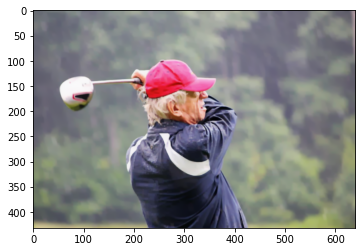

In [ ]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('slow/003.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

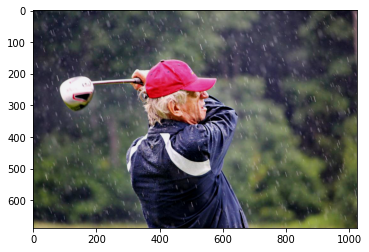

In [ ]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('results/natural/Transweather/003.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [ ]:
!rm -rf results/natural results/outdoor

In [ ]:
!python test_real.py -exp_name=./Transweather

Seed:	19
cuda
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
--- Testing starts! ---
348.png
412.png
374.png
360.png
406.png
638.png
176.png
610.png
604.png
162.png
002.png
016.png
228.png
566.png
200.png
214.png
572.png
599.png
215.png
573.png
567.png
201.png
229.png
017.png
003.png
605.png
163.png
177.png
611.png
639.png
407.png
413.png
375.png
349.png
363.png
377.png
411.png
149.png
161.png
607.png
613.png
175.png
015.png
001.png
559.png
571.png
203.png
565.png
202.png
564.png
570.png
216.png
558.png
014.png
028.png
612.png
174.png
160.png
606.png
389.png
376.png
410.png
404.png
36

In [ ]:
!zip -r results_preproc_star_dehazed.zip ./results/
!cp results_preproc_star_dehazed.zip /content/drive/MyDrive/derain/

updating: results/ (stored 0%)
updating: results/natural/ (stored 0%)
updating: results/natural/Transweather/ (stored 0%)
updating: results/natural/Transweather/647.png (deflated 0%)
updating: results/natural/Transweather/137.png (deflated 0%)
updating: results/natural/Transweather/637.png (deflated 0%)
updating: results/natural/Transweather/270.png (deflated 0%)
updating: results/natural/Transweather/498.png (deflated 0%)
updating: results/natural/Transweather/007.png (deflated 0%)
updating: results/natural/Transweather/518.png (deflated 0%)
updating: results/natural/Transweather/408.png (deflated 0%)
updating: results/natural/Transweather/197.png (deflated 0%)
updating: results/natural/Transweather/055.png (deflated 0%)
updating: results/natural/Transweather/603.png (deflated 0%)
updating: results/natural/Transweather/131.png (deflated 0%)
updating: results/natural/Transweather/191.png (deflated 0%)
updating: results/natural/Transweather/053.png (deflated 0%)
updating: results/natura